In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, callbacks

# Define the input shape
input_shape = (32, 32, 3)

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test0) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test0, 10)


# Complex modulation - Haoyan's paper

Epoch 1/1000
1563/1563 [==============================] - 26s 16ms/step - loss: 1.7938 - accuracy: 0.3625 - val_loss: 1.6728 - val_accuracy: 0.3989
Epoch 2/1000
1563/1563 [==============================] - 25s 16ms/step - loss: 1.6076 - accuracy: 0.4317 - val_loss: 1.6112 - val_accuracy: 0.4267
Epoch 3/1000
1563/1563 [==============================] - 24s 16ms/step - loss: 1.5303 - accuracy: 0.4609 - val_loss: 1.5211 - val_accuracy: 0.4607
Epoch 4/1000
1563/1563 [==============================] - 25s 16ms/step - loss: 1.4721 - accuracy: 0.4814 - val_loss: 1.5165 - val_accuracy: 0.4655
Epoch 5/1000
1563/1563 [==============================] - 25s 16ms/step - loss: 1.4275 - accuracy: 0.4926 - val_loss: 1.4533 - val_accuracy: 0.4882
Epoch 6/1000
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3864 - accuracy: 0.5076 - val_loss: 1.4492 - val_accuracy: 0.4899
Epoch 7/1000
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3447 - accuracy: 0.5236 - val_

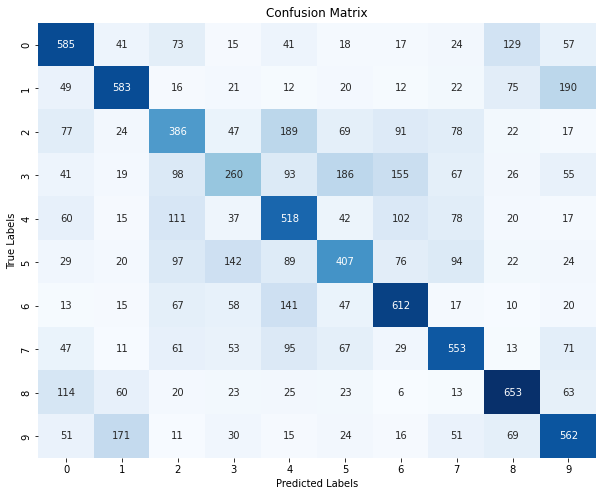

In [21]:
# Input shape
input_shape = (32, 32, 3)  # Example input shape

# Input layer
input_layer = Input(shape=input_shape)

# Convert input to complex numbers
def complex_input(x):
    real = x
    imag = tf.zeros_like(x)  # Initialize imaginary part with zeros
    return tf.complex(real, imag)

complex_input_layer = Lambda(complex_input)(input_layer)

# Fourier Transform
def fourier_transform(x):
    return tf.signal.fft2d(x)

fft_layer = Lambda(fourier_transform)(complex_input_layer)

# Create complex trainable weights for 16 channels
num_channels = 16  # 16 channels
complex_weight_real = tf.Variable(tf.ones((32, 32, num_channels), dtype=tf.float32), trainable=True)
complex_weight_imag = tf.Variable(tf.ones((32, 32, num_channels), dtype=tf.float32), trainable=True)

# Define a custom layer for complex multiplication with 16 channels
class ComplexMultiplyLayer(Layer):
    def __init__(self, real_weight, imag_weight):
        super(ComplexMultiplyLayer, self).__init__()
        self.real_weight = real_weight
        self.imag_weight = imag_weight

    def call(self, inputs):
        real_input = tf.math.real(inputs)
        imag_input = tf.math.imag(inputs)

        # Perform complex multiplication with 16 channels
        real_outputs = []
        imag_outputs = []
        for i in range(num_channels):
            real_output = real_input * self.real_weight[:, :, i:i+1]
            imag_output = imag_input * self.imag_weight[:, :, i:i+1]
            real_outputs.append(real_output)
            imag_outputs.append(imag_output)

        real_outputs = tf.concat(real_outputs, axis=-1)
        imag_outputs = tf.concat(imag_outputs, axis=-1)

        complex_output = tf.complex(real_outputs, imag_outputs)
        return complex_output

# Complex multiplication layer with 16 channels
complex_multiply_layer = ComplexMultiplyLayer(complex_weight_real, complex_weight_imag)

# Apply complex multiplication
output_layer = complex_multiply_layer(fft_layer)

# Inverse Fourier Transform
def inverse_fourier_transform(x):
    return tf.signal.ifft2d(x)

ifft_layer = Lambda(inverse_fourier_transform)(output_layer)

# Camera layer with 16 channels
class ComplexSquaringLayer(Layer):
    def __init__(self, **kwargs):
        super(ComplexSquaringLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Split the complex input into real and imaginary parts
        real_part = tf.math.real(inputs)
        imag_part = tf.math.imag(inputs)
        
        # Square both real and imaginary parts
        real_squared = tf.square(real_part)
        imag_squared = tf.square(imag_part)
        
        # Combine the squared parts back into complex numbers
        squared_complex = (real_squared + imag_squared)
        
        return squared_complex

camera = ComplexSquaringLayer()(ifft_layer)

# Flatten the output of the camera layer
flatten_layer = Flatten()(camera)

# Fully connected layers
fc1 = Dense(128, activation='relu')(flatten_layer)
fc2 = Dense(64, activation='relu')(fc1)

# Output layer
output_layer = Dense(10, activation='softmax')(fc2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model (assuming you have x_train, y_train, x_test, y_test defined)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Predict labels for the test set
predicted_labels = model.predict(x_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Create a confusion matrix
confusion = confusion_matrix(y_test0, predicted_classes)

# Plot the confusion matrix with numbers at each block
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Amplitude modulation only

Epoch 1/1000
1563/1563 [==============================] - 26s 16ms/step - loss: 1.8264 - accuracy: 0.3488 - val_loss: 1.7224 - val_accuracy: 0.3980
Epoch 2/1000
1563/1563 [==============================] - 24s 16ms/step - loss: 1.6508 - accuracy: 0.4155 - val_loss: 1.6080 - val_accuracy: 0.4249
Epoch 3/1000
1563/1563 [==============================] - 24s 15ms/step - loss: 1.5732 - accuracy: 0.4438 - val_loss: 1.5615 - val_accuracy: 0.4546
Epoch 4/1000
1563/1563 [==============================] - 24s 15ms/step - loss: 1.5179 - accuracy: 0.4645 - val_loss: 1.5458 - val_accuracy: 0.4593
Epoch 5/1000
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4763 - accuracy: 0.4794 - val_loss: 1.4936 - val_accuracy: 0.4699
Epoch 6/1000
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4448 - accuracy: 0.4892 - val_loss: 1.4862 - val_accuracy: 0.4794
Epoch 7/1000
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4114 - accuracy: 0.5005 - val_

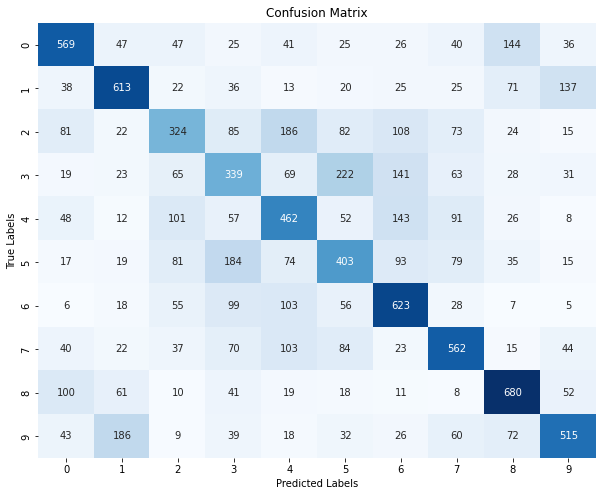

In [22]:

# Input shape
input_shape = (32, 32, 3)  # Example input shape

# Input layer
input_layer = Input(shape=input_shape)

# Convert input to complex numbers
def complex_input(x):
    real = x
    imag = tf.zeros_like(x)  # Initialize imaginary part with zeros
    return tf.complex(real, imag)

complex_input_layer = Lambda(complex_input)(input_layer)

# Fourier Transform
def fourier_transform(x):
    return tf.signal.fft2d(x)

fft_layer = Lambda(fourier_transform)(complex_input_layer)

# Create complex trainable weights for 16 channels
num_channels = 16  # 16 channels
complex_weight_real = tf.Variable(tf.ones((32, 32, num_channels), dtype=tf.float32), trainable=True)
#complex_weight_imag = tf.Variable(tf.zeros((32, 32, num_channels), dtype=tf.float32), trainable=True)

# Define a custom layer for complex multiplication with 16 channels
class ComplexMultiplyLayer(Layer):
    def __init__(self, real_weight):
        super(ComplexMultiplyLayer, self).__init__()
        self.real_weight = real_weight

    def call(self, inputs):
        real_input = tf.math.real(inputs)
        imag_input = tf.math.imag(inputs)

        # Perform complex multiplication with 16 channels
        real_outputs = []
        imag_outputs = []
        for i in range(num_channels):
            real_output = real_input * self.real_weight[:, :, i:i+1]
            imag_output = imag_input * self.real_weight[:, :, i:i+1]
            real_outputs.append(real_output)
            imag_outputs.append(imag_output)

        real_outputs = tf.concat(real_outputs, axis=-1)
        imag_outputs = tf.concat(imag_outputs, axis=-1)

        complex_output = tf.complex(real_outputs, imag_outputs)
        return complex_output

# Complex multiplication layer with 16 channels
complex_multiply_layer = ComplexMultiplyLayer(complex_weight_real)

# Apply complex multiplication
output_layer = complex_multiply_layer(fft_layer)

# Inverse Fourier Transform
def inverse_fourier_transform(x):
    return tf.signal.ifft2d(x)

ifft_layer = Lambda(inverse_fourier_transform)(output_layer)

# Camera layer with 16 channels
class ComplexSquaringLayer(Layer):
    def __init__(self, **kwargs):
        super(ComplexSquaringLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Split the complex input into real and imaginary parts
        real_part = tf.math.real(inputs)
        imag_part = tf.math.imag(inputs)
        
        # Square both real and imaginary parts
        real_squared = tf.square(real_part)
        imag_squared = tf.square(imag_part)
        
        # Combine the squared parts back into complex numbers
        squared_complex = real_squared + imag_squared
        
        return squared_complex

camera = ComplexSquaringLayer()(ifft_layer)

# Flatten the output of the camera layer
flatten_layer = Flatten()(camera)

# Fully connected layers
fc1 = Dense(128, activation='relu')(flatten_layer)
fc2 = Dense(64, activation='relu')(fc1)

# Output layer
output_layer = Dense(10, activation='softmax')(fc2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model (assuming you have x_train, y_train, x_test, y_test defined)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Predict labels for the test set
predicted_labels = model.predict(x_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Create a confusion matrix
confusion = confusion_matrix(y_test0, predicted_classes)

# Plot the confusion matrix with numbers at each block
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Phase only modulation

Epoch 1/1000
1563/1563 [==============================] - 58s 35ms/step - loss: 1.8196 - accuracy: 0.3531 - val_loss: 1.6665 - val_accuracy: 0.4126
Epoch 2/1000
1563/1563 [==============================] - 55s 35ms/step - loss: 1.6428 - accuracy: 0.4213 - val_loss: 1.5980 - val_accuracy: 0.4332
Epoch 3/1000
1563/1563 [==============================] - 55s 35ms/step - loss: 1.5729 - accuracy: 0.4443 - val_loss: 1.5806 - val_accuracy: 0.4460
Epoch 4/1000
1563/1563 [==============================] - 55s 35ms/step - loss: 1.5238 - accuracy: 0.4619 - val_loss: 1.5275 - val_accuracy: 0.4610
Epoch 5/1000
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4912 - accuracy: 0.4729 - val_loss: 1.5120 - val_accuracy: 0.4719
Epoch 6/1000
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4621 - accuracy: 0.4828 - val_loss: 1.5119 - val_accuracy: 0.4652
Epoch 7/1000
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4343 - accuracy: 0.4921 - val_

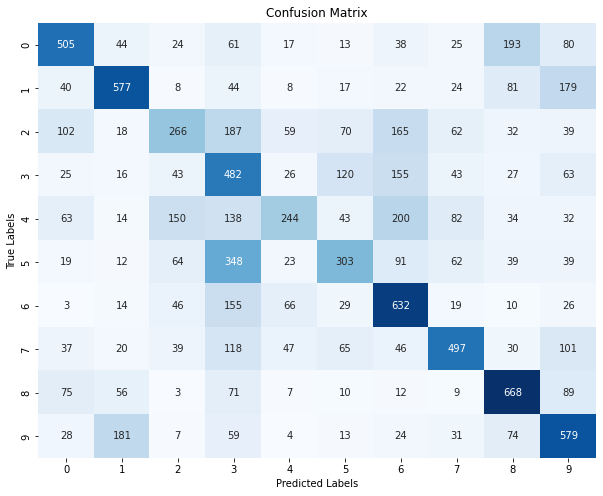

In [19]:

# Input shape
input_shape = (32, 32, 3)  # Example input shape

# Input layer
input_layer = Input(shape=input_shape)

# Convert input to complex numbers
def complex_input(x):
    real = x
    imag = tf.zeros_like(x)  # Initialize imaginary part with zeros
    return tf.complex(real, imag)

complex_input_layer = Lambda(complex_input)(input_layer)

# Fourier Transform
def fourier_transform(x):
    return tf.signal.fft2d(x)

fft_layer = Lambda(fourier_transform)(complex_input_layer)

# Create complex trainable weights for 16 channels
num_channels = 16  # 16 channels
complex_weight_real = tf.Variable(tf.ones((32, 32, num_channels), dtype=tf.float32), trainable=True)
#complex_weight_imag = tf.Variable(tf.zeros((32, 32, num_channels), dtype=tf.float32), trainable=True)

# Define a custom layer for complex multiplication with 16 channels
class ComplexMultiplyLayer(Layer):
    def __init__(self, real_weight):
        super(ComplexMultiplyLayer, self).__init__()
        self.real_weight = real_weight

    def call(self, inputs):
        real_input = tf.math.real(inputs)
        imag_input = tf.math.imag(inputs)

        # Perform complex multiplication with 16 channels
        real_outputs = []
        imag_outputs = []
        for i in range(num_channels):

            real_output = real_input * tf.math.cos(self.real_weight[:, :, i:i+1] ) - imag_input * tf.math.sin(self.real_weight[:, :, i:i+1]  )
            imag_output = imag_input * tf.math.cos(self.real_weight[:, :, i:i+1]  ) + real_input * tf.math.sin(self.real_weight[:, :, i:i+1]  )
            real_outputs.append(real_output)
            imag_outputs.append(imag_output)

        real_outputs = tf.concat(real_outputs, axis=-1)
        imag_outputs = tf.concat(imag_outputs, axis=-1)

        complex_output = tf.complex(real_outputs, imag_outputs)
        return complex_output

# Complex multiplication layer with 16 channels
complex_multiply_layer = ComplexMultiplyLayer(complex_weight_real)

# Apply complex multiplication
output_layer = complex_multiply_layer(fft_layer)

# Inverse Fourier Transform
def inverse_fourier_transform(x):
    return tf.signal.ifft2d(x)

ifft_layer = Lambda(inverse_fourier_transform)(output_layer)

# Camera layer with 16 channels
class ComplexSquaringLayer(Layer):
    def __init__(self, **kwargs):
        super(ComplexSquaringLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Split the complex input into real and imaginary parts
        real_part = tf.math.real(inputs)
        imag_part = tf.math.imag(inputs)
        
        # Square both real and imaginary parts
        real_squared = tf.square(real_part)
        imag_squared = tf.square(imag_part)
        
        # Combine the squared parts back into complex numbers
        squared_complex = real_squared + imag_squared
        
        return squared_complex

camera = ComplexSquaringLayer()(ifft_layer)

# Flatten the output of the camera layer
flatten_layer = Flatten()(camera)

# Fully connected layers
fc1 = Dense(128, activation='relu')(flatten_layer)
fc2 = Dense(64, activation='relu')(fc1)

# Output layer
output_layer = Dense(10, activation='softmax')(fc2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model (assuming you have x_train, y_train, x_test, y_test defined)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Predict labels for the test set
predicted_labels = model.predict(x_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Create a confusion matrix
confusion = confusion_matrix(y_test0, predicted_classes)

# Plot the confusion matrix with numbers at each block
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# without fourier layer

Epoch 1/1000
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8841 - accuracy: 0.3142 - val_loss: 1.7476 - val_accuracy: 0.3608
Epoch 2/1000
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7055 - accuracy: 0.3904 - val_loss: 1.6671 - val_accuracy: 0.4045
Epoch 3/1000
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6371 - accuracy: 0.4163 - val_loss: 1.5934 - val_accuracy: 0.4354
Epoch 4/1000
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5873 - accuracy: 0.4347 - val_loss: 1.6022 - val_accuracy: 0.4258
Epoch 5/1000
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5548 - accuracy: 0.4463 - val_loss: 1.6004 - val_accuracy: 0.4304
Epoch 6/1000
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5226 - accuracy: 0.4585 - val_loss: 1.5413 - val_accuracy: 0.4553
Epoch 7/1000
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5041 - accuracy: 0.4644 - val_loss: 1.5204 -

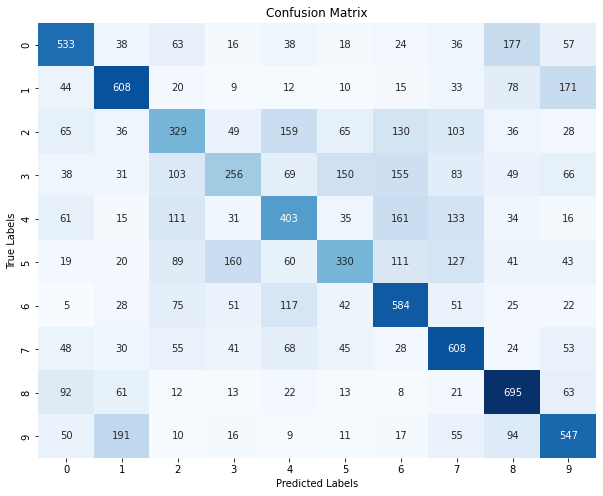

In [20]:

# Input shape
input_shape = (32, 32, 3)  # Example input shape

# Input layer
input_layer = Input(shape=input_shape)


# Flatten the output of the camera layer
flatten_layer = Flatten()(input_layer)

# Fully connected layers
fc1 = Dense(128, activation='relu')(flatten_layer)
fc2 = Dense(64, activation='relu')(fc1)

# Output layer
output_layer = Dense(10, activation='softmax')(fc2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model (assuming you have x_train, y_train, x_test, y_test defined)
model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Predict labels for the test set
predicted_labels = model.predict(x_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Create a confusion matrix
confusion = confusion_matrix(y_test0, predicted_classes)

# Plot the confusion matrix with numbers at each block
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
